# User-User Recommendations

This is one of the most basic ways of making recommendations: finding nearest neighbors for each user (users who seem to enjoy and dislike the same products as our user), and recommending the products these users have liked and our user has not seen yet. 

## Opening the Data

We're putting all the data into a sparse matrix. 

In [64]:
import numpy as np
from scipy.sparse import lil_matrix

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
users,movies = list(),list()

for line in data_file.readlines():
    line = line.split()
    user = int(line[0])
    movie = int(line[1])
    users.append(user)
    movies.append(movie)

users = np.unique(users)
movies = np.unique(movies)

user_to_id = dict(zip(users,range(len(users))))
movie_to_id = dict(zip(movies,range(len(movies))))
id_to_user = dict(zip(range(len(users)),users))
id_to_movie = dict(zip(range(len(movies)),movies))

data = lil_matrix((len(users),len(movies)))

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
for line in data_file.readlines():
    line = line.split()
    user = user_to_id[int(line[0])]
    movie = movie_to_id[int(line[1])]
    rating = int(line[2])
    data[user,movie] = rating

## Computing Means and Deviation

We define a rating as the sum of a user's mean rating and their deviance on the rating. 

A new prediction will be made by taking the user for whom we're making a prediction's mean rating, and adding the weighted sum of its closest neighbors. 

Neighbors can be positive (similar) or negative (opposite). We use both those inter-user relations to measure our predicted deviance on a movie. 

In [19]:
user_means = data.sum(axis=1).A.reshape(-1)/data.getnnz(axis=1)
movie_means = data.sum(axis=0).A.reshape(-1)/data.getnnz(axis=0)

user_dev = data-user_means.reshape(-1,1)
movie_dev = data-movie_means

## Measure Weights between Users

We're going to compare users to try to find those who are most different (negative weights) or similar (positive weights). We'll then use those correlations to predict a rating of movies our user has not seen yet. 

These weights take a little bit of time to compute, so we'll save them. The code underneath checks whether a file already exists, and loads it if it does. If it doesn't, it computes the correlation coefficients and saves them.

We're using the formula for the Pearson correlation to compute weights between users. 
Worth noting: weights are symmetrical, so we only need to calculate half the matrix. The diagonal will obviously be full of ones, so we don't need to compute that either. 

In [20]:
import os
import math

# see if weights file already exists
if os.path.isfile('weights.npy'): weights = np.load('weights.npy')

# otherwise, create it
else:
    
    # intersection_min = min number of movies users must have in common
    # to be considered useful in each other's calculations
    intersection_min = 10
    
    weights = np.zeros((len(users),len(users)))
    for user in id_to_user:
        # user_rated = list of movies our user has rated
        user_rated = data[user].nonzero()[1]
        # only look at neighbors with superior id (to only compute half the matrix)
        for neighbor in list(id_to_user.keys())[user+1:]:
            # neighbor_rated = list of movies this neighbor has rated
            neighbor_rated = data[neighbor].nonzero()[1]
            intersection = np.intersect1d(user_rated,neighbor_rated)
            if len(intersection)>intersection_min:
                # Pearson correlation formula
                numerator = sum([user_dev[user,movie]*user_dev[neighbor,movie] for movie in intersection])
                denominator1 = math.sqrt(sum([user_dev[user,movie]**2 for movie in user_rated]))
                denominator2 = math.sqrt(sum([user_dev[neighbor,movie]**2 for movie in neighbor_rated]))
                weights[user,neighbor] = numerator/(denominator1*denominator2)
    np.save('weights',weights)

### Sorting Neighbors

We're using absolute distances between users to sort them, because a very dissimilar user is just as important as a very similar user. 

In [21]:
absolute_weights = abs(weights)
for i in id_to_user:
    for j in list(id_to_user.keys())[user+1:]:
        absolute_weights[j,i] = absolute_weights[i,j]

neighborhood = np.flip(absolute_weights.argsort(),axis=1)

## Making Predictions

This takes a bit of computing time too, so we'll check again whether a saved file already exists before we make predictions from scratch.

The code underneath will make predictions for all users and save the whole completed matrix to your computer. That's a dense matrix of shape (943,1682), so it has 1,586,126 values in it. 

We use this formula to compute our new rating predictions for user i on product p:

sum(correlation_ij * deviance_jp) / sum(abs(correlation_ij) 

where j are the selected neighbors for our user. 

Our numerator operations are directly applied to our data matrix, and the denominators are calculated in a dictionary and applied to the matrix at the end of the numerator calculations. 

In [56]:
import time

if os.path.isfile('completed_data.pkl'): completed_data = pickle.load(open('completed_data.pkl','rb'))

else: 

    n_neighbors = 30
    entries = list(zip(*data.nonzero()))
    intersection_min = 10
    start = time.time()

    for user in id_to_user:
        #print(user+1,'/',len(id_to_user))
        denominators = dict()
        user_rated = data[user].nonzero()[1]
        neighbors = neighborhood[user,:n_neighbors]
        for neighbor in neighbors:
            neighbor_rated = data[neighbor].nonzero()[1]
            intersection = np.intersect1d(user_rated,neighbor_rated)
            # movies that are in the neighbor's ratings but not the intersection
            movies_to_rate = np.setdiff1d(neighbor_rated,intersection)
            for movie in movies_to_rate:
                if movie in denominators: denominators[movie] += absolute_weights[user,neighbor]
                else: denominators[movie] = [absolute_weights[user,neighbor]]
                data[user,movie] += weights[min(user,neighbor),max(user,neighbor)]*user_dev[neighbor,movie]
        # movies that weren't rated by our user
        movies_changed = np.setdiff1d(movies-1,user_rated)
        for movie in movies_changed: 
            if movie in denominators and denominators[movie]!=0: 
                data[user,movie] = user_means[user]+(data[user,movie]/denominators[movie])
            else: data[user,movie] = user_means[user]
            data[user,movie] = max(round(data[user,movie]),1)
            data[user,movie] = min(data[user,movie],5)

    print('That took',time.time()-start,'seconds.')
    #pickle.dump(data,open('completed_data.pkl','wb'))

That took 48.906891107559204 seconds.


That whole matrix might be a bit much, so another idea would be to make predictions for one user at a time. 
Here's a function that will let you do that:

In [65]:
entries = list(zip(*data.nonzero()))

def predict_user(user,n_neighbors,intersection_min):
    predictions = data[user].copy()
    denominators = dict()
    user_rated = predictions.nonzero()[1]
    predictions = predictions.toarray()[0]
    neighbors = neighborhood[user,:n_neighbors]
    for neighbor in neighbors: 
        neighbor_rated = data[neighbor].nonzero()[1]
        intersection = np.intersect1d(user_rated,neighbor_rated)
        # movies that are in the neighbor's ratings but not the intersection
        movies_to_rate = np.setdiff1d(neighbor_rated,intersection)
        for movie in movies_to_rate:
            if movie in denominators: denominators[movie] += absolute_weights[user,neighbor]
            else: denominators[movie] = [absolute_weights[user,neighbor]]
            predictions[movie] += weights[min(user,neighbor),max(user,neighbor)]*user_dev[neighbor,movie]
    # movies that weren't rated by our user
    movies_changed = np.setdiff1d(movies-1,user_rated)
    for movie in movies_changed: 
        if movie in denominators and denominators[movie]!=0: 
            predictions[movie] = user_means[user]+(predictions[movie]/denominators[movie])
        else: predictions[movie] = user_means[user]
        # You can set boundaries to ratings and round them if you like, but it's not mandatory.
        # You'll also lose a lot of ranking information. 
        # However, if you wanna do it, uncomment these lines:
        #predictions[movie] = max(round(predictions[movie]),1)
        #predictions[movie] = min(predictions[movie],5)
    return predictions

start = time.time()
predictions = predict_user(0,30,5)
print('That took',time.time()-start,'seconds.')

That took 0.03966069221496582 seconds.


##  Looking at our Predictions

So we've found a way to make very quick predictions for a user on all the products they haven't rated, using only the ratings we were provided with. 

We can't really evaluate our model with a proper metric, as this is all unsupervised learning. What we can do though is try to see whether our predictions seem to make sense, by looking at the high-rated movies of a user, and the movies our model would recommend them. 

We've chosen not to limit or round our values, so we have all the ranking information.

### Making Recommendations

First, we need to translate our predictions into recommendations for our users.

For that, we'll simply look at the movies our user hasn't rated yet, remove them from the pool of potential recommendations, and then recommend movies in order of their predicted rating. 

In [84]:
def make_recommendations(user,n_recs):
    user_rated = data[user].nonzero()[1]
    recommendation_pool = np.setdiff1d(movies-1,user_rated)
    # ditionaries to move from absolute index to index within the recommendation pool and vice versa
    global_to_rec = dict(zip(recommendation_pool,range(len(recommendation_pool))))
    rec_to_global = dict(zip(range(len(recommendation_pool)),recommendation_pool))
    
    all_ratings = predict_user(user,30,5)
    rec_pool_ratings = all_ratings[recommendation_pool]
    ranking = np.flip(rec_pool_ratings.argsort(),axis=0)
    recommendations = np.array([rec_to_global[ranking[i]] for i in range(n_recs)])
    return recommendations
    
start = time.time()
user = 500
recommendations = make_recommendations(user,10)
print("Movies recommended for user "+str(user)+': '+' '.join(recommendations.astype(str)))
print('made in',time.time()-start,'seconds')

Movies recommended for user 500: 370 1427 997 174 522 960 643 639 130 505
made in 0.06494975090026855 seconds


### Evaluation by the Naked Eye

We're now going to look at what our predictions look like when we look at the movies we recommend. 

First, we'll get the titles for our movies:

In [88]:
item_data_file = 'ml-100k/u.item'
item_data_file = open(item_data_file,'r',encoding='utf-8',errors='ignore')
movie_titles = dict()

for line in item_data_file.readlines():
    line = line.split('|')[:2]
    movie_titles[int(line[0])] = line[1]
    
print(movie_titles[1])

Toy Story (1995)


The following function takes in a user, displays their top-rated movies, makes predictions on what to recommend them, and then displays that too. 

In [143]:
def get_top_movies(user,n):
    user_rated = data[user].nonzero()[1]
    global_to_rated = dict(zip(user_rated,range(len(user_rated))))
    rated_to_global = dict(zip(range(len(user_rated)),user_rated))
    ratings = data[user].toarray()[0][user_rated]
    ranking = [rated_to_global[movie] for movie in np.flip(ratings.argsort(),axis=0)][:n]
    return ranking
    

def recommended_movies(user,n_recs,n_tops):
    
    # find top 10 movies for our user (if they have at least 10)
    user = user_to_id[user]
    ranking = get_top_movies(user,n_tops)
    ranking = [id_to_movie[r] for r in ranking]
    top_titles = [movie_titles[r] for r in ranking]
    
    # make recommendations
    recommendations = make_recommendations(user,n_recs)
    recommendations = [id_to_movie[m] for m in recommendations]
    rec_titles = [movie_titles[r] for r in recommendations]
    
    print('\nTop movies:')
    print('\n'.join(top_titles))
    print('\nRecommendations:')
    print('\n'.join(rec_titles))
    
user = 100
recommended_movies(user,10,10)


Top movies:
Titanic (1997)
As Good As It Gets (1997)
Apt Pupil (1998)
L.A. Confidential (1997)
Wag the Dog (1997)
Conspiracy Theory (1997)
Sphere (1998)
Seven Years in Tibet (1997)
Dark City (1998)
Amistad (1997)

Recommendations:
Raise the Red Lantern (1991)
Return of the Jedi (1983)
Braveheart (1995)
Star Wars (1977)
Remains of the Day, The (1993)
Emma (1996)
Twelfth Night (1996)
Sleepers (1996)
Fierce Creatures (1997)
Primal Fear (1996)


We can also make a TSNE representation of our movies to get an idea of how close our recommendations are to the user's top movies. 

Here's how we get all the movies' genres:
(Movies can be several genres at once. Genres are booleans.)

There's also a TSNE representation of all our movies, using their genre vectors. 

Example of a genre vector: [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


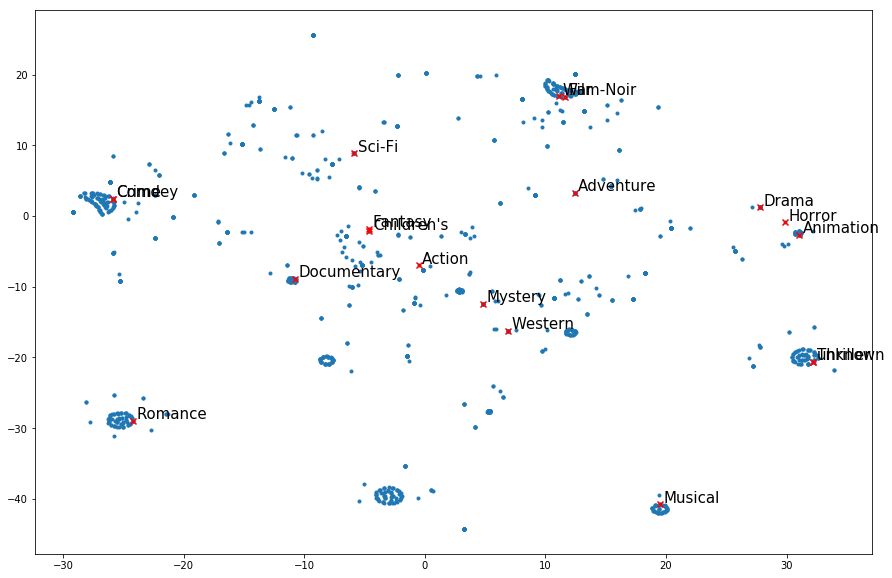

In [144]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

item_data_file = 'ml-100k/u.item'
item_data_file = open(item_data_file,'r',encoding='utf-8',errors='ignore')
movie_genres = dict()

for line in item_data_file.readlines():
    line = line.split('|')
    id = int(line[0])
    movie_genres[id] = np.array(line[5:]).astype(int)
    
n_genres = len(movie_genres[1])

genres_matrix = np.zeros((len(movie_genres)+n_genres,n_genres),dtype=int)

for movie,genres in movie_genres.items(): genres_matrix[movie-1] = genres
    
for i in range(n_genres): 
    rep = np.zeros(n_genres)
    rep[i] = 1
    genres_matrix[len(movie_genres)+i] = rep
    
print('Example of a genre vector:',genres_matrix[0])

tsne = TSNE()

reduced = tsne.fit_transform(genres_matrix)
x = reduced[:-n_genres,0]
y = reduced[:-n_genres,1]

plt.scatter(x,y,marker='.')

genres = ['unknown','Action','Adventure','Animation','Children\'s','Comdey','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

for i in range(len(genres)):
    plt.scatter(reduced[n_genres+i,0],reduced[n_genres+i,1],marker='x',c='red')
    plt.text(reduced[n_genres+i,0]+.3,reduced[n_genres+i,1]+.3,genres[i],fontsize=15)

plt.show()

Let's now write a function that lets you see all movies, highlighting the top ones for a chosen user in one color, and the recommendations we've predicted in another. 

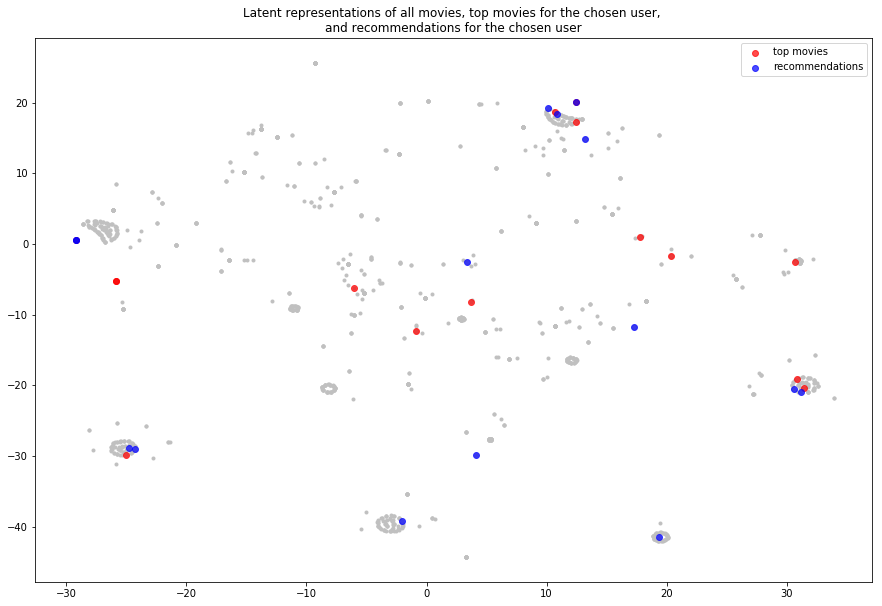

In [160]:
def see_movies_for_user(user):
    top_movies = get_top_movies(user,15)
    recommendations = make_recommendations(user,15)
    plt.scatter(x,y,marker='.',c='silver')
    plt.scatter(x[top_movies],y[top_movies],marker='o',c='red',alpha=.7,label='top movies')
    plt.scatter(x[recommendations],y[recommendations],marker='o',c='blue',alpha=.7,label='recommendations')
    plt.legend()
    plt.title("Latent representations of all movies, top movies for the chosen user, \nand recommendations for the chosen user")
    plt.show()
    
see_movies_for_user(500)

To get a sense of how well our model is working, I'll let you try to see our movie recommendations in title lists and TSNE representations for different user ids :)